# Decision Tree Regressor

In following [notebook](https://github.com/jyotipmahes/Implementation-of-ML-algos-in-Python/blob/master/Decision%20Tree%20Classifier.ipynb), we saw how to implement **DecisionTree Clasifier**. 

In this notebook we will implement **Decision Tree for regression**. The logic of tree building will remain same with slight modification in implementation. We will try a slight different approach to explore different ways in which we can implement the same logic. Note that previous implementation structure can also be used by changing the splitting criterion and prediction function. We calculate **variance** here as splitting criterion.

### 1. Decision Tree initialization

This time we will not use a fit method as used in previous classification notebook. Hence, we will do most of the heavy lifting during initialization step only. Here are the things we initialize in this step:
1. `x` : Feature values of the data(ndarray)
2. `y` : Target Value(a vector)
3. `idx` : Refers to the data index's related to given node
4. `min_leaf`: Minimum data points required on leaf node. Another way to **avoid over fitting** instead of using `max_depth`
5. `n`: Number of data points corresponding to the node
6. `c`: Number of features
7. `val`: It is the mean of the target value associated to the node
8. `score`: Variance score for node. 
9. `find_varsplit` : It finds the best split for the tree and starts splitting if possible.

In [1]:
import math
import numpy as np

In [2]:
class DecisionTreeReg():
    def __init__(self, x, y, idxs, min_leaf=5):
        self.x = x
        self.y = y
        self.idxs = idxs
        self.min_leaf = min_leaf
        self.n = len(idxs)
        self.c = x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()

### 2. Splitting criterion
For **regression** we use variance(Mean Square Error) as the splitting criterion which determines split.

Reduction in variance is an algorithm used for continuous target variables (regression problems). This algorithm uses the standard formula of variance to choose the best split. **The split with lower variance is selected as the criteria to split the population:**

$$ var = \sum\frac{(X-\bar(X))^2}{n}$$

which is also equal to:

$$ var = {\frac{\sum{x^2}}{n} - \bar(x)^2}$$


Steps to calculate Variance:

1. Calculate variance for each node.
2. Calculate variance for each split as weighted average of each node variance.
3. Compare with parent node and find the best split possible with lowest variance.

The function given below calculate the variance using second formula. `cnt` is n, `s1` is $\sum(x)$ and `s2` is $\sum(x^2)$

In [3]:
def std_agg(cnt, s1, s2): 
    return (s2/cnt) - (s1/cnt)**2

### 3. Finding best split point for a column/feature

The objective here is to find the best split and we can take similar approach as last time. But will try a different way this time which is much more efficient. Here are the steps we will take to find best split:
1. Store the x and y values for given column and given node by selecting column and row indexes.
2. Sort the x value based on which we will split the data. Use the same order for y as well.
3. We start by assigning all the data points to the right side of the child node and store the count, sum of x and sum of x^2 which are required for variance calculation.
4. We assign no data point to left side and hence we get 0 as count, sum and sum of x^2.
5. Now we run a for loop ranging from 0 to number of items on node - min_leaf-1. This is to ensure that we have min_leaf data points after split.
6. As we loop through in the given range, we start assigning one data point at a time to left side by removing it from right side split. So, we update the count, sum and sum of x^2 accordingly. We also ensure that min_leaf data points are initialized first to left side before we compare the splits.
7. Now we calculate the weighted sum of the variance of the new split and compare it with the parent node to find the best split point.
8. Once we find the best split, we update the column index `var_idx`, `score` and `split` referring to best split value.

In [4]:
def find_better_split(self, var_idx):
    x = self.x.values[self.idxs,var_idx]
    y = self.y[self.idxs]
    sort_idx = np.argsort(x)
    sort_y = y[sort_idx]
    sort_x = x[sort_idx]
    rhs_cnt = self.n 
    rhs_sum = sort_y.sum()
    rhs_sum2 = (sort_y**2).sum()
    lhs_cnt = 0
    lhs_sum = 0.
    lhs_sum2 = 0.

    for i in range(0,self.n-self.min_leaf-1):
        xi = sort_x[i]
        yi = sort_y[i]
        lhs_cnt += 1
        rhs_cnt -= 1
        lhs_sum += yi
        rhs_sum -= yi
        lhs_sum2 += yi**2
        rhs_sum2 -= yi**2
        if i<self.min_leaf or xi==sort_x[i+1]:
            continue

        lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
        rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
        curr_score = lhs_std*lhs_cnt/len(y) + rhs_std*rhs_cnt/len(y)
        if curr_score<self.score: 
            self.var_idx = var_idx
            self.score = curr_score
            self.split = xi

### 4. Finding best split point and column
We will now write a wrapper function, which check all the columns in the data to find the best column and best split as shown below. Once we find the best split column and split value, we create two child nodes as `left` and `right` and assign corresponding data points to each. Note `self.split_col` is a class property which gets the column value for best split column. For more understanding on `class property` refer to previous [notebook](https://github.com/jyotipmahes/Implementation-of-ML-algos-in-Python/blob/master/Decision%20Tree%20Classifier.ipynb)

In [5]:
@property
def split_col(self): return self.x.values[self.idxs,self.var_idx]
    
def find_varsplit(self):
    for i in range(self.c): 
        self.find_better_split(i)
        
    if self.score == float('inf'): return
    x = self.split_col
    lhs = np.nonzero(x<=self.split)[0]
    rhs = np.nonzero(x>self.split)[0]
    self.lhs = DecisionTree(self.x, self.y, self.idxs[lhs])
    self.rhs = DecisionTree(self.x, self.y, self.idxs[rhs])

### Few more property which can come handy
**split_name**: It gets the name of column on which given node is split<br>
**is_leaf**: Checks if given node is leaf or not<br>
**__repr__**: Assigning string representation to the object. Helpful while printing and displaying

In [6]:
@property
def split_name(self): return self.x.columns[self.var_idx]

@property
def is_leaf(self): return self.score == float('inf')

def __repr__(self):
    s = f'n: {self.n}; val:{self.val}'
    if not self.is_leaf:
        s += f'; score:{self.score}; split:{self.split}; var:{self.split_name}'
    return s

### 5. Making prediction on test data:
`predict_row` function transverse the tree by comparing the test data to splitting criterion till it reaches leaf. At leaf, it return the `self.val` which the mean of the training data points corresponding to the leaf.

`predict` runs above function on all the test points and returns an array.

In [7]:
def predict_row(self, xi):
    if self.is_leaf: return self.val
    t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
    return t.predict_row(xi) 

def predict(self, x):
    return np.array([self.predict_row(xi) for xi in x])

## Putting Everything together

In [8]:
def std_agg(cnt, s1, s2): 
    return (s2/cnt) - (s1/cnt)**2

class DecisionTreeReg():
    
    def __init__(self, x, y, idxs, min_leaf=5):
        self.x = x
        self.y = y
        self.idxs = idxs
        self.min_leaf = min_leaf
        self.n = len(idxs)
        self.c = x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()
    
    def find_better_split(self, var_idx):
        x = self.x.values[self.idxs,var_idx]
        y = self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y = y[sort_idx]
        sort_x = x[sort_idx]
        rhs_cnt = self.n 
        rhs_sum = sort_y.sum()
        rhs_sum2 = (sort_y**2).sum()
        lhs_cnt = 0
        lhs_sum = 0.
        lhs_sum2 = 0.

        for i in range(0,self.n-self.min_leaf-1):
            xi = sort_x[i]
            yi = sort_y[i]
            lhs_cnt += 1
            rhs_cnt -= 1
            lhs_sum += yi
            rhs_sum -= yi
            lhs_sum2 += yi**2
            rhs_sum2 -= yi**2
            if i<self.min_leaf or xi==sort_x[i+1]:
                continue

            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std*lhs_cnt/self.n + rhs_std*rhs_cnt/self.n
            if curr_score<self.score: 
                self.var_idx = var_idx
                self.score = curr_score
                self.split = xi  
    
    @property
    def split_col(self): return self.x.values[self.idxs,self.var_idx]

    def find_varsplit(self):
        for i in range(self.c): 
            self.find_better_split(i)

        if self.score == float('inf'): return
        x = self.split_col
        lhs = np.nonzero(x<=self.split)[0]
        rhs = np.nonzero(x>self.split)[0]
        self.lhs = DecisionTreeReg(self.x, self.y, self.idxs[lhs])
        self.rhs = DecisionTreeReg(self.x, self.y, self.idxs[rhs])

        
    @property
    def split_name(self): return self.x.columns[self.var_idx]

    @property
    def is_leaf(self): return self.score == float('inf')

    def __repr__(self):
        s = f'n: {self.n}; val:{self.val}'
        if not self.is_leaf:
            s += f'; score:{self.score}; split:{self.split}; var:{self.split_name}'
        return s

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
        return t.predict_row(xi) 

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

## Checking Implementation

In [9]:
from sklearn.datasets import load_boston
import pandas as pd
bos = load_boston()
x = bos.data
y = bos.target
x_df = pd.DataFrame(x, columns=bos.feature_names)

In [10]:
reg = DecisionTreeReg(x_df, y, np.array(range(0, len(y))))


In [11]:
pred = reg.predict(np.array(x_df))

In [12]:
sum((y-pred)**2)/(len(y))

7.879892243296889

#### Using sklearn

In [13]:
from sklearn.tree import DecisionTreeRegressor
skreg = DecisionTreeRegressor(min_samples_leaf=6)

In [14]:
skreg.fit(x,y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=6,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [15]:
pred = skreg.predict(x)

In [16]:
sum((y-pred)**2)/(len(y))

7.879892243296889

**We can see that our prediction matches with skelearn's prediction**

### Visualizing Decision Tree

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import datasets
from IPython.display import Image  
from sklearn import tree
import pydotplus

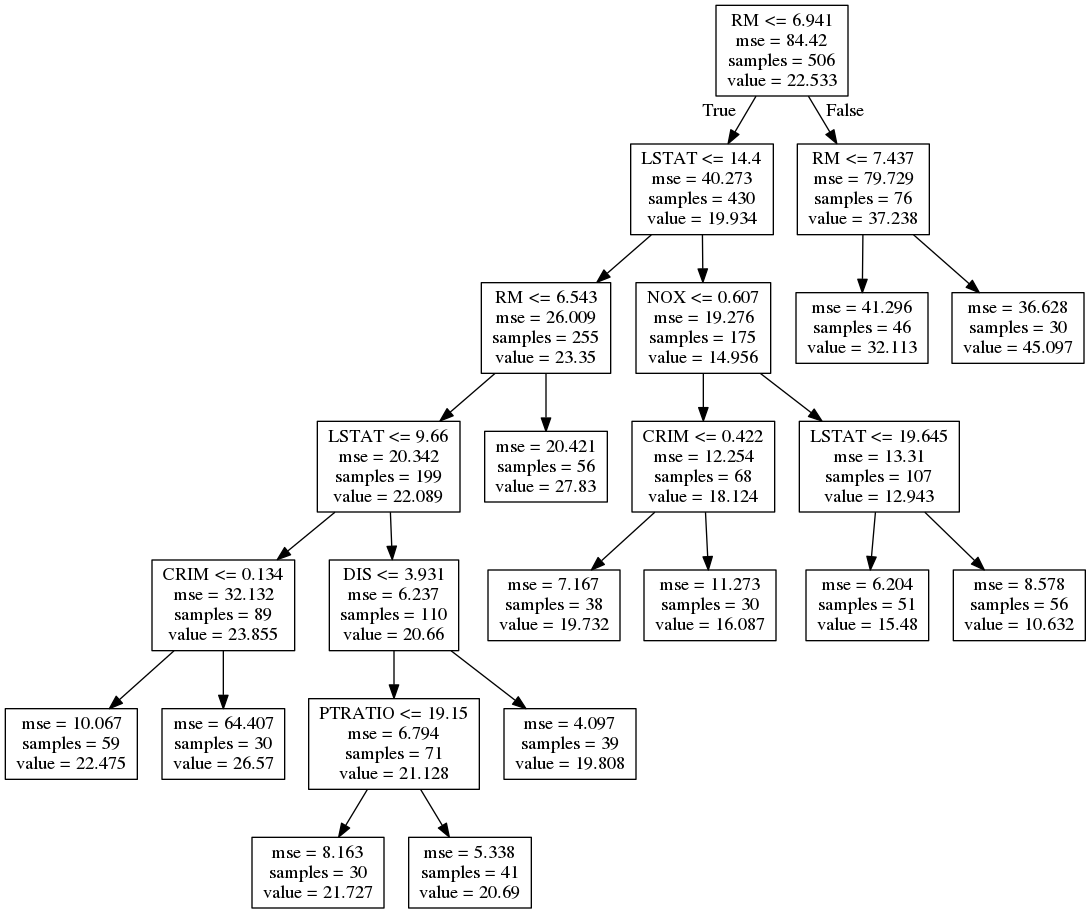

In [18]:
from sklearn.tree import DecisionTreeRegressor
skreg = DecisionTreeRegressor(min_samples_leaf=30)
skreg.fit(x,y)

# Create DOT data
dot_data = tree.export_graphviz(skreg, out_file=None, 
                                feature_names=bos.feature_names,  
                                class_names=bos.target)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())